# Forecasting data from magnetometer stations with Prophet library.

## Install libraries.

In [2]:
# !pip install -r requirements.txt

## Import necessary libraries and set up the environment.

In [5]:
import prophet
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.offline as py
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

from sklearn.impute import KNNImputer

In [9]:
from etna.analysis import (cross_corr_plot, distribution_plot, plot_anomalies,
                           plot_anomalies_interactive, plot_backtest,
                           plot_correlation_matrix, plot_forecast)
from etna.analysis.outliers import (get_anomalies_density, get_anomalies_hist,
                                    get_anomalies_median,
                                    get_anomalies_prediction_interval)
from etna.transforms import (DateFlagsTransform, FilterFeaturesTransform,
                             HolidayTransform, LagTransform,
                             LinearTrendTransform, LogTransform, MeanTransform,
                             MedianOutliersTransform, SegmentEncoderTransform,
                             TimeSeriesImputerTransform)
from etna.datasets import TSDataset

Disable logger outputs from Prophet and cmdstanpy:

In [10]:
import logging

logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

logging.getLogger('prophet').setLevel(logging.WARNING)

## Data processing and review.

In [11]:
original_df = pd.read_csv("data/main_row_data.text", sep='\s+', na_values=99999.9)[['YYYY', 'MM', 'DD', 'HH', 'MM.1', 'SS', 'KEV_X']]
original_df.rename(columns={"MM.1": "mm"}, inplace=True)
original_df.head()

,YYYY,MM,DD,HH,mm,SS,KEV_X
0,1983,1,4,1,0,0,NaN
1,1983,1,4,2,0,0,NaN
2,1983,1,4,3,0,0,NaN
3,1983,1,4,4,0,0,NaN
4,1983,1,4,5,0,0,NaN


Fill missing dates

In [12]:
original_df.insert(0, 'date', original_df.apply(lambda x: datetime.datetime(int(x.YYYY), int(x.MM), int(x.DD), int(x.HH), int(x.mm), int(x.SS)), axis=1))
original_df.drop(columns=['YYYY', 'MM', 'DD', 'HH', 'mm', 'SS'], inplace=True)
original_df.set_index('date', inplace=True)
original_df = original_df.asfreq('H').reset_index()

In [13]:
original_df[original_df.KEV_X.notnull()].head()

,date,KEV_X
3969,1983-06-18 10:00:00,11280.3
3970,1983-06-18 11:00:00,11379.3
3971,1983-06-18 12:00:00,11442.1
3972,1983-06-18 13:00:00,11454.0
3973,1983-06-18 14:00:00,11369.1


Convert data to a format necessary for the Prophet library:

In [14]:
df = original_df.rename(columns={'date': 'ds',
                                'KEV_X': 'y'})
df.ds = pd.to_datetime(df.ds, format='%Y-%m-%d %H:%M:%S')
df.head()

,ds,y
0,1983-01-04 01:00:00,NaN
1,1983-01-04 02:00:00,NaN
2,1983-01-04 03:00:00,NaN
3,1983-01-04 04:00:00,NaN
4,1983-01-04 05:00:00,NaN


Amount of data:

In [15]:
df.shape

(357359, 2)

What raw time series data looks like.

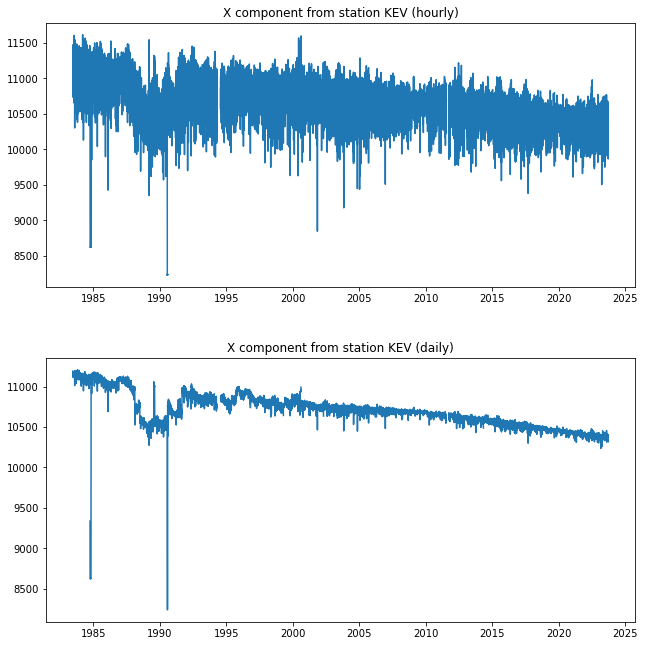

In [16]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
fig.tight_layout(pad=5.0)
ax1.plot(df.ds, df.y)
ax1.set_title('X component from station KEV (hourly)')
ax2.plot(df.resample('1D', on='ds').mean().reset_index().ds, df.resample('1D', on='ds').mean().y)
ax2.set_title('X component from station KEV (daily)')
plt.show()

Data before 2003 is not of very good quality, so we will not use it:

In [17]:
df = df[df.ds > datetime.datetime.strptime('2003-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')].reset_index(drop=True)
df.head()

,ds,y
0,2003-01-01 01:00:00,10758.1
1,2003-01-01 02:00:00,10757.7
2,2003-01-01 03:00:00,10746.4
3,2003-01-01 04:00:00,10752.3
4,2003-01-01 05:00:00,10760.8


Train and test split:

In [173]:
train_size = int(df.shape[0] * 0.8)
test_size = df.shape[0] - train_size

df_train = df[:train_size].copy(deep=True)
df_val = df[train_size:int(train_size + test_size / 2)].copy(deep=True)
df_test = df[int(train_size + test_size / 2):].copy(deep=True)

df_train.shape, df_val.shape, df_test.shape

((145688, 2), (18211, 2), (18212, 2))

In [19]:
def fill_missing_values(dataframe, method):
    dataframe = dataframe.copy(deep=True)
    if method == 'default':
        return dataframe
    # fill with mean.
    if method == 'mean':
        return dataframe.fillna(dataframe.mean(numeric_only=True).round(1))
    # fill with median.
    if method == 'median':
        return dataframe.fillna(dataframe.median(numeric_only=True).round(1))
    # fill with knn method.
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=15)
        dataframe = dataframe.apply(lambda col: imputer.fit_transform(col.to_numpy().reshape(-1, 1)).T[0] if col.name != "ds" else col)
        return dataframe

    return dataframe

Functions that can handle missing values to calculate metrics:

In [20]:
def calc_mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.nanmean((y_true - y_pred) ** 2)

def calc_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.nanmean(np.abs((y_true - y_pred) / y_true)) * 100

def calc_smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.nanmean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true)) / 2)) * 100

Function that evaluates model and finds mse, mape and smape metrics:

In [191]:
def evaluate_model(model, df_test):
    future = df_test[['ds']]
    forecast = model.predict(future)

    predictions = forecast.iloc[-len(df_test):]['yhat']
    actuals = df_test['y']

    mse = calc_mse(actuals, predictions)
    mape = calc_mape(actuals, predictions)
    smape = calc_smape(actuals, predictions)

    return mse, mape, smape, list(actuals), list(predictions)

Find best method (by mse metric) for filling missing values:

In [ ]:
methods = ['default', 'mean', 'median', 'knn']
mses = {"mse":[]}

for method in tqdm(methods, position=0, leave=True):
    # Replace nan values.
    no_nan_df = fill_missing_values(df_train, method)
    no_nan_df.reset_index(inplace=True)
    model = Prophet()
    model.fit(no_nan_df)

    mse, _, _, _, _ = evaluate_model(model, df_val)
    mses['mse'] += [mse]

print(f"\nBest method: {methods[np.argmin(mses['mse'])]}")
fill_mv_results = pd.DataFrame(mses)
fill_mv_results.insert(0, 'methods', methods)
fill_mv_results.sort_values("mse").reset_index(drop=True)

100%|██████████| 4/4 [05:02<00:00, 75.61s/it]


Best method: default


,methods,mse
0,default,3418.323797
1,knn,3421.828935
2,mean,3427.187072
3,median,3439.820967


Normalizing data:

In [174]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train.y = scaler.fit_transform(np.array(df_train.y).reshape(-1, 1)).T[0]
df_val.y = scaler.transform(np.array(df_val.y).reshape(-1, 1)).T[0]
df_test.y = scaler.transform(np.array(df_test.y).reshape(-1, 1)).T[0]

Let's look at model performance on data with outliers:

In [134]:
model_with_outliers = Prophet()
model_with_outliers.fit(df_train.reset_index())
mse, mape, smape, _, _ = evaluate_model(model_with_outliers, df_val)

print(f'mse: {mse}, mape: {mape}, smape: {smape}')

mse: 0.23968424770719376, mape: 26.209962461314102, smape: 19.169793376366076


Now we will try to find best algorithm for outlier detection.<br>
We will use method <b>based on deviation from median values calculated over a window</b>.<br>
We bring the dataset into a form convenient for the etna library

In [175]:
df_etna = df_train.copy(deep=True)
df_etna["timestamp"] = df_etna["ds"]
df_etna["target"] = df_etna["y"]
df_etna.drop(columns=["ds", "y"], inplace=True)
df_etna["segment"] = "main"
df_etna = TSDataset.to_dataset(df_etna)
df_etna.head()

segment,main
feature,target
timestamp,
2003-01-01 01:00:00,1.084372
2003-01-01 02:00:00,1.081022
2003-01-01 03:00:00,0.986397
2003-01-01 04:00:00,1.035803
2003-01-01 05:00:00,1.106982


In [136]:
def from_etna_to_pandas(ts_etna):
    df_cleaned = ts_etna.to_pandas()
    df_cleaned.columns = [' '.join(col).strip() for col in df_cleaned.columns.values]
    df_cleaned.reset_index(inplace=True)
    df_cleaned = df_cleaned.rename(columns={"main target": "target"})
    df_cleaned = df_cleaned.rename(columns={"timestamp": "ds", "target": "y"})
    return df_cleaned

In [65]:
param_grid = {
    'window_size': [50, 100, 150, 200, 250, 300],
    'alpha': [1, 2, 3, 4, 5, 6],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
metrics = {"mape":[], "mse":[], "smape":[]}

for params in tqdm(all_params, position=0, leave=True):
    m = Prophet()
    
    outliers_remover = MedianOutliersTransform(in_column="target", **params)
    ts_etna = TSDataset(df_etna, freq="H")
    ts_etna.fit_transform([outliers_remover])
    
    m.fit(from_etna_to_pandas(ts_etna).reset_index())

    mse, mape, smape, _, _ = evaluate_model(m, df_val)
    metrics['mse'] += [mse]
    metrics['mape'] += [mape]
    metrics['smape'] += [smape]

best_params = all_params[np.argmin(metrics['mape'])]
print("\nBest params: ", best_params)

outliers_detection_results = pd.DataFrame(all_params)
outliers_detection_results = outliers_detection_results.join(pd.DataFrame.from_dict(metrics))
outliers_detection_results.sort_values("mape").reset_index(drop=True)

100%|███████████████████████████████████████████| 36/36 [26:11<00:00, 43.65s/it]


Best params:  {'window_size': 100, 'alpha': 1}


,window_size,alpha,mape,mse,smape
0,100,1,22.199548,0.241044,0.241044
1,50,1,22.247966,0.242295,0.242295
2,150,1,22.301109,0.238955,0.238955
3,200,1,22.321625,0.238301,0.238301
4,250,1,22.393111,0.236938,0.236938
5,300,1,22.422937,0.236575,0.236575
6,100,2,23.225059,0.229618,0.229618
7,150,2,23.307103,0.228610,0.228610
8,250,2,23.318788,0.228569,0.228569
9,200,2,23.334446,0.228195,0.228195


Vizualize detected outliers:

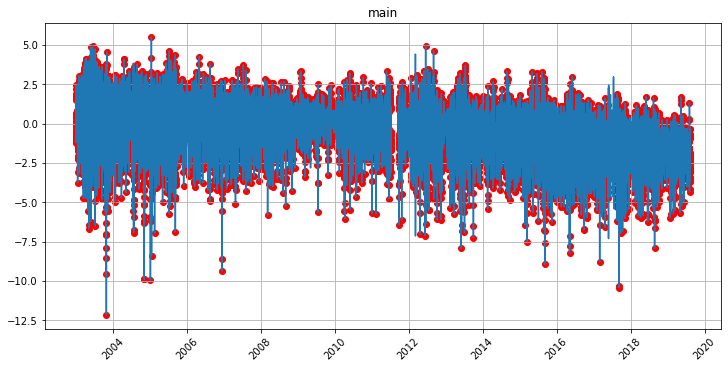

In [182]:
ts_etna = TSDataset(df_etna, freq="H")
anomaly_dict = get_anomalies_median(ts_etna, **best_params)
plot_anomalies(ts_etna, anomaly_dict)

Drop outliers from df_train:

In [183]:
outliers_remover = MedianOutliersTransform(in_column="target", window_size=100, alpha=1)
ts_etna.fit_transform([outliers_remover])
df_train = from_etna_to_pandas(ts_etna)

Number of detected outliers:

In [184]:
len(anomaly_dict['main'])

23555

In [194]:
m = Prophet()
m.fit(df_train.reset_index())
mse, mape, smape, actuals, predictions = evaluate_model(m, df_val)

print(f'mse: {mse}, mape: {mape}, smape: {smape}')

mse: 0.2410435093621071, mape: 22.199547643126092, smape: 14.142390831519998


Visualize train and test data without outliers:

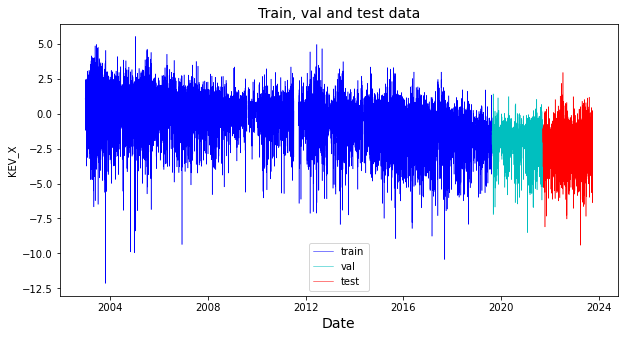

In [163]:
plt.figure(figsize=(10,5))

plt.plot(df_train.ds, df_train.y, color='b', label='train', linewidth=0.5)
plt.plot(df_val.ds, df_val.y, color='c', label='val', linewidth=0.5)
plt.plot(df_test.ds, df_test.y, color='r', label='test', linewidth=0.5)

plt.xlabel("Date", fontsize=14)
plt.ylabel("KEV_X")
plt.title("Train, val and test data", fontsize=14)

plt.legend()

plt.show()

## Model training.

In [150]:
df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)
df_test.reset_index(inplace=True)

Let's look at baseline model performance:

In [153]:
baseline_model = Prophet()
baseline_model.fit(df_train)

In [154]:
mse, mape, smape, _, _ = evaluate_model(baseline_model, df_val)

print(f'mse: {mse}, mape: {mape}, smape: {smape}')

mse: 0.37111955063050195, mape: 56.11902762381655, smape: 19.91546994321057


Let's look at model performance by changing chengepoint_range. The best model was with the default changepoint_range parameter (=0.8)

In [ ]:
metrics = {"mape":[], "mse":[], "smape":[]}
crs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for cr in tqdm(crs, position=0, leave=True):
    m = Prophet(changepoint_range=cr)
    m.fit(df_train)

    mse, mape, smape, _, _ = evaluate_model(m, df_val)
    metrics['mse'] += [mse]
    metrics['mape'] += [mape]
    metrics['smape'] += [smape]


print(f"\nBest changepoint_range: {crs[np.argmin(metrics['mape'])]}")
chose_changepoint_range_results = pd.DataFrame({"changepoint_ranges": crs})
chose_changepoint_range_results = chose_changepoint_range_results.join(pd.DataFrame.from_dict(metrics))
chose_changepoint_range_results.sort_values("mape").reset_index(drop=True)

100%|██████████| 9/9 [10:22<00:00, 69.12s/it]


Best changepoint_range: 0.4


,changepoint_ranges,mape,mse,smape
0,0.4,25.688602,0.241784,0.241784
1,0.5,25.698447,0.240338,0.240338
2,0.3,25.808375,0.248770,0.248770
3,0.6,25.859919,0.237624,0.237624
4,0.8,25.869991,0.237559,0.237559
5,0.9,25.875110,0.237546,0.237546
6,0.7,26.084403,0.237030,0.237030
7,0.2,26.320567,0.263688,0.263688
8,0.1,27.525163,0.292182,0.292182


Automatic hyperparameter tuning by MSE metric:

In [ ]:
%%time
metrics = {"mape":[], "mse":[], "smape":[]}

# Set up parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'seasonality_prior_scale': [8, 9, 10, 11, 12],
    'seasonality_mode': ['additive', 'multiplicative'],
    'n_changepoints' : [25, 50, 100, 150],
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# Create a list to store MAPE values for each combination
mses = []

for params in tqdm(all_params, position=0, leave=True):
    # Fit a model using one parameter combination
    m = Prophet(**params, changepoint_range=0.4)
    m.fit(df_train)

    mse, mape, smape, _, _ = evaluate_model(m, df_val)
    metrics['mse'] += [mse]
    metrics['mape'] += [mape]
    metrics['smape'] += [smape]

best_params = all_params[np.argmin(metrics['mape'])]
print("\nBest params: ", best_params)

tuning_results = pd.DataFrame(all_params)
tuning_results = tuning_results.join(pd.DataFrame.from_dict(metrics))
tuning_results.sort_values("mape").reset_index(drop=True)

  1%|          | 1/120 [01:23<2:45:14, 83.31s/it]


KeyboardInterrupt: ignored

Fit model with tuned parameters:

In [ ]:
tuned_model = Prophet(changepoint_range=0.4, changepoint_prior_scale=0.005, seasonality_prior_scale=10, seasonality_mode='additive')
tuned_model.fit(df_train)

mse, mape, smape, actuals, predictions = evaluate_model(tuned_model, df_val)

print(f'mse: {mse}, mape: {mape}, smape: {smape}')

mse: 0.2423305400960979, mape: 25.692390231823232, smape: 19.584132926807698


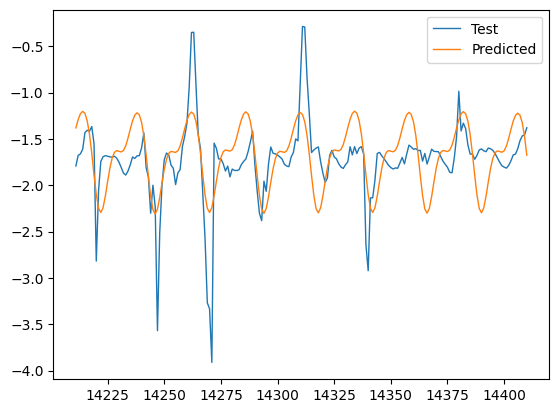

In [ ]:
plt.plot(actuals[-4000:-3800], label='Test', linewidth=1)
plt.plot(predictions[-4000:-3800], label='Predicted', linewidth=1)
plt.legend()
plt.show()

In [ ]:
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(tuned_model))  # Save model